# Wrangle "@weratedogs" twitter data
The objective of this document is to wrangle the tweet archive of @weratedogs user on twitter. To inspect the data and augment it with other sources of information including by fetching data from twitter API. Once the data is gathered from all sources, the data will be inspected and cleaned.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import requests # to make http requests
import tweepy # to work with the twitter api

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# file and URL names to process
twitter_archive_file = 'twitter_archive_enhanced.csv'
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_predictions_file = 'image_predictions.tsv'
tweets_file = 'tweet_json.txt'

## Gather
Get data from the initially known data sources

### Gather from downloaded WeRateDogs twitter archive

In [3]:
twitter_archive = pd.read_csv(twitter_archive_file)
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Gather from TSV file

In [7]:
# Download the file from the provided url
res = requests.get(image_predictions_url)
with open(image_predictions_file, 'wb') as file:
    file.write(res.content)

In [8]:
# Read the TSV file from filesystem
image_predictions = pd.read_csv(image_predictions_file, sep='\t')
image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


## Assess
Understand the obtained data a little before fetching the tweets

In [5]:
twitter_archive.shape

(2356, 17)

In [6]:
image_predictions.shape

(2075, 12)

## Gather
### Gather tweets from twitter using an API
__`twitter_archive` table__ has more lines of data, hence let us fetch the tweets based on this

In [7]:
# get keys and secrets from the environment
import os
consumer_key = os.environ['TWITTER_API_KEY']
consumer_secret = os.environ['TWITTER_API_SECRET']
access_token = os.environ['TWITTER_ACCESS_TOKEN']
access_token_secret = os.environ['TWITTER_ACCESS_SECRET']

In [8]:
# Initialize the tweepy library 
import tweepy
import json
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [9]:
# get the full tweet json for each tweet and write to a file one line per tweet
with open(tweets_file, 'w') as file:
    # statuses_lookup can fetch 100 tweets at a time
    # take 100 tweets at a time from twitter_archive
    for index in range(0, len(twitter_archive), 100):
        id_list = twitter_archive.tweet_id.iloc[index:index+100]
        try:
            statuses = api.statuses_lookup(id_list.array)
            for status in statuses:
                file.write(json.dumps(status._json) + '\n')
        except Exception as e:
            print(str(e))

### Gather the tweets data that was stored as a JSON file

In [10]:
# read this data into a dataframe
detailed_tweets = pd.read_json(tweets_file, lines=True)
detailed_tweets.head(1)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,NaN,2017-06-18 16:57:37,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,18141,False,NaN,876484053909872640,876484053909872640,...,NaN,NaN,NaN,2264,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He wants to thank you for th...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [11]:
# check for the size of the data
detailed_tweets.shape

(2333, 29)

## Assess

### Analyze the `twitter_archive` data

In [12]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
857,763956972077010945,7.638652e+17,15846407.0,2016-08-12 04:35:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@TheEllenShow I'm not sure if you know this bu...,NaN,NaN,NaN,NaN,12,10,None,doggo,None,None,None
284,838921590096166913,NaN,NaN,2017-03-07 01:17:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Arlo. He's officially the king of snow...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838921590...,13,10,Arlo,None,None,None,None
1646,683834909291606017,NaN,NaN,2016-01-04 02:18:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see a faulty pupper. Might need to rep...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683834909...,9,10,None,None,None,pupper,None
1209,715696743237730304,NaN,NaN,2016-04-01 00:26:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Toby. He's a Lithuanian High-Steppin Stic...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715696743...,10,10,Toby,None,None,None,None
2282,667211855547486208,NaN,NaN,2015-11-19 05:24:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Genevieve. She is a golden retriever c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667211855...,9,10,Genevieve,None,None,None,None
1986,672884426393653248,NaN,NaN,2015-12-04 21:05:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Marvelous dog here. Rad ears. Not very soft. L...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672884426...,6,10,None,None,None,None,None
2296,667090893657276420,NaN,NaN,2015-11-18 21:23:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clybe. He is an Anemone Valdez. One ea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667090893...,7,10,Clybe,None,None,None,None
666,790581949425475584,NaN,NaN,2016-10-24 15:53:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Duke. He sneaks into the fridge someti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790581949...,11,10,Duke,None,None,None,None
1761,678675843183484930,NaN,NaN,2015-12-20 20:38:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Exotic pup here. Tail long af. Throat looks sw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678675843...,2,10,None,None,None,None,None
47,883117836046086144,NaN,NaN,2017-07-07 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please only send dogs. We don't rate mechanics...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883117836...,13,10,None,None,None,None,None


In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# checking that records with in_reply_to_status_id data also has in_reply_to_user_id data
twitter_archive[twitter_archive.in_reply_to_status_id.notnull() & twitter_archive.in_reply_to_user_id.isnull()].shape

(0, 17)

In [22]:
# total records with in_reply_to_status_id, and in_reply_to_user_id should be 78
reply_mask = twitter_archive.in_reply_to_status_id.notnull() & twitter_archive.in_reply_to_user_id.notnull()
twitter_archive[reply_mask].shape

(78, 17)

In [98]:
# check the tweets part of this
with pd.option_context('display.max_colwidth', -1): 
    print(twitter_archive[reply_mask].sample(10).text)

1446    After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me                                       
189     @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10       
1501    These are some pictures of Teddy that further justify his 13/10 rating. Please enjoy https://t.co/tDkJAnQsbQ                                
1882    Ok last one of these. I may try to make some myself. Anyway here ya go. 13/10 https://t.co/i9CDd1oEu8                                       
1844    This dog is being demoted to a 9/10 for not wearing a helmet while riding. Gotta stay safe out there. Thank you                             
291     @bragg6of8 @Andy_Pace_ we are still looking for the first 15/10                                                                             
843     His name is Charley and he already has a new set of wheels thanks to donations. I heard his top sp

- tweet 1882 - Is a set of memes
- tweet 184 - Is a follow-up post of a dog that's been rated and the rating has been upgraded. 

In [32]:
# let's check some low ratings
twitter_archive[twitter_archive.rating_numerator < 6].sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1941,673715861853720576,NaN,NaN,2015-12-07 04:09:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a heavily opinionated dog. Loves walls...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673715861...,4,10,a,None,None,None,None
1680,682003177596559360,NaN,NaN,2015-12-30 01:00:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unique dog here. Wrinkly as hell. Weird segmen...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682003177...,5,10,None,None,None,None,None
1727,679877062409191424,NaN,NaN,2015-12-24 04:11:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Penelope. She's a bacon frise. Total babe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679877062...,5,10,Penelope,None,None,None,None
1979,672980819271634944,NaN,NaN,2015-12-05 03:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extraordinary dog here. Looks large. Just a he...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672980819...,5,10,None,None,None,None,None
2183,668989615043424256,NaN,NaN,2015-11-24 03:08:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bernie. He's taking his Halloween cost...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668989615...,3,10,Bernie,None,None,None,None
2079,670826280409919488,NaN,NaN,2015-11-29 04:47:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Scary dog here. Too many legs. Extra tail. Not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670826280...,2,10,None,None,None,None,None
2288,667176164155375616,NaN,NaN,2015-11-19 03:02:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are strange dogs. All have toupees. Long...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667176164...,4,10,None,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
1629,684567543613382656,NaN,NaN,2016-01-06 02:49:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bobby. He doesn't give a damn about pe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684567543...,4,10,Bobby,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None


In [112]:
twitter_archive.iloc[315].expanded_urls

'https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1'

In [120]:
twitter_archive.iloc[2317].expanded_urls

'https://twitter.com/dog_rates/status/666644823164719104/photo/1'

In [33]:
twitter_archive.iloc[1680].expanded_urls

'https://twitter.com/dog_rates/status/682003177596559360/photo/1'

In [128]:
# how many such low ratings below 10 are there?
twitter_archive[twitter_archive.rating_numerator < 10].shape

(440, 17)

In [34]:
# let check some high ratings
twitter_archive[twitter_archive.rating_numerator > 15].sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [110]:
twitter_archive.iloc[979].expanded_urls

'https://twitter.com/dog_rates/status/749981277374128128/photo/1'

In [35]:
twitter_archive.iloc[1635].expanded_urls

'https://twitter.com/dog_rates/status/684222868335505415/photo/1'

In [129]:
# how many ratings > 15 are there?
twitter_archive[twitter_archive.rating_numerator > 15].shape

(26, 17)

In [47]:
# investigate the top ratings
twitter_archive.rating_numerator.sort_values(ascending=False).head(26)

979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
1635     121
1228      99
1843      88
433       84
1254      80
695       75
340       75
1351      60
1202      50
1274      45
1433      44
763       27
1712      26
516       24
1663      20
55        17
Name: rating_numerator, dtype: int64

In [49]:
twitter_archive.iloc[979].expanded_urls

'https://twitter.com/dog_rates/status/749981277374128128/photo/1'

In [50]:
twitter_archive.iloc[1228].expanded_urls

'https://twitter.com/dog_rates/status/713900603437621249/photo/1'

In [53]:
# checking denominators
twitter_archive.rating_denominator.sort_values().head(10)

313      0
2335     2
516      7
1576    10
1575    10
1574    10
1573    10
1572    10
1563    10
1570    10
Name: rating_denominator, dtype: int64

In [54]:
# denominators < 10??
twitter_archive[twitter_archive.rating_denominator < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [55]:
twitter_archive.iloc[516].expanded_urls

'https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1'

In [56]:
twitter_archive.iloc[2335].expanded_urls

'https://twitter.com/dog_rates/status/666287406224695296/photo/1'

In [61]:
# investigate the denominators > 10
twitter_archive.rating_denominator.sort_values(ascending=False).head(25)

1120    170
902     150
1634    130
1779    120
1635    110
1228     90
1254     80
1843     80
433      70
1274     50
1351     50
1202     50
1433     40
1598     20
1165     20
1663     16
342      15
1662     11
1068     11
784      11
800      10
778      10
777      10
776      10
779      10
Name: rating_denominator, dtype: int64

In [63]:
pd.set_option('display.max_colwidth', -1)
twitter_archive[twitter_archive.rating_denominator > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a hr

In [201]:
denom_10_20_mask = (twitter_archive.rating_denominator > 10) & (twitter_archive.rating_denominator < 20)
twitter_archive[denom_10_20_mask].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1663,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None


In [200]:
twitter_archive[twitter_archive.name == "None"].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
1979,672980819271634944,NaN,NaN,2015-12-05 03:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extraordinary dog here. Looks large. Just a he...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672980819...,5,10,None,None,None,None,None
2099,670717338665226240,NaN,NaN,2015-11-28 21:34:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*screams for a little bit and then crumples to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670717338...,12,10,None,None,None,None,None
1324,706169069255446529,NaN,NaN,2016-03-05 17:26:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",He was doing his best. 12/10 I'll be his lawye...,NaN,NaN,NaN,https://twitter.com/wgnnews/status/70616592080...,12,10,None,None,None,None,None
1871,675147105808306176,NaN,NaN,2015-12-11 02:56:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're presenting a group project and the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675147105...,10,10,None,None,None,None,None


In [211]:
twitter_archive[twitter_archive.name == "None"].shape

(745, 17)

In [219]:
# checking how many dogs where state is not identified
state_mask = (twitter_archive.doggo == "None") & (twitter_archive.floofer == "None") & (twitter_archive.pupper == "None") & (twitter_archive.puppo == "None")
twitter_archive[state_mask].shape

(1976, 17)

#### Analyze the `image_predictions` data

In [68]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
103,667806454573760512,https://pbs.twimg.com/media/CUSGbXeVAAAgztZ.jpg,1,toyshop,0.253089,False,Chihuahua,0.187155,True,Brabancon_griffon,0.112799,True
584,678969228704284672,https://pbs.twimg.com/media/CWwu6OLUkAEo3gq.jpg,1,Labrador_retriever,0.680251,True,Chesapeake_Bay_retriever,0.201697,True,golden_retriever,0.019676,True
1697,816697700272001025,https://pbs.twimg.com/media/C1V-K63UAAEUHqw.jpg,1,Chihuahua,0.756992,True,Pomeranian,0.052850,True,Maltese_dog,0.047608,True
880,698635131305795584,https://pbs.twimg.com/ext_tw_video_thumb/698635005506015234/pu/img/wQ4yFXTZ-2QLt68b.jpg,1,Samoyed,0.158464,True,kuvasz,0.089402,True,West_Highland_white_terrier,0.025037,True
186,669363888236994561,https://pbs.twimg.com/media/CUoO1TLWsAA0Z3w.jpg,1,golden_retriever,0.539004,True,Irish_setter,0.406550,True,cocker_spaniel,0.041484,True
439,674436901579923456,https://pbs.twimg.com/media/CVwUyM9WwAAGDjv.jpg,1,acorn_squash,0.375392,False,Shih-Tzu,0.105416,True,Lhasa,0.072832,True
1459,778027034220126208,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True
172,669000397445533696,https://pbs.twimg.com/media/CUjETvDVAAI8LIy.jpg,1,Pembroke,0.822940,True,Cardigan,0.177035,True,basenji,0.000023,True
390,673363615379013632,https://pbs.twimg.com/media/CVhEoq4WcAE8pBm.jpg,1,ox,0.193431,False,warthog,0.123827,False,bison,0.111177,False
1820,834458053273591808,https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg,1,Rhodesian_ridgeback,0.468619,True,whippet,0.177531,True,redbone,0.106552,True


In [69]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [70]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [74]:
# check for duplicate tweet ids
image_predictions.tweet_id.duplicated().sum()

0

In [75]:
# how many entries where first guess is not a dog
image_predictions[image_predictions.p1_dog == False].shape

(543, 12)

In [79]:
# how many entries where none of the guesses are a dog
none_mask = (image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False)
image_predictions[none_mask].shape

(324, 12)

In [78]:
# how many entries where first guess is not a dog, but other guesses are a dog
image_predictions[(image_predictions.p1_dog == False) & ((image_predictions.p2_dog == True) | (image_predictions.p3_dog == True))].shape

(219, 12)

In [247]:
# see some samples for none_mask
image_predictions[none_mask].sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1143,730196704625098752,https://pbs.twimg.com/media/CiIuBwCUgAAAGbz.jpg,1,hand_blower,0.296145,False,chain_mail,0.262271,False,toilet_seat,0.149497,False
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,1,sorrel,0.811520,False,horse_cart,0.024820,False,Arabian_camel,0.015155,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,0.190142,False,wig,0.034510,False
209,669972011175813120,https://pbs.twimg.com/media/CUw3_QiUEAA8cT9.jpg,1,teddy,0.953071,False,koala,0.007027,False,fur_coat,0.005368,False
618,680221482581123072,https://pbs.twimg.com/media/CXCh0QZW8AALdXm.jpg,1,bubble,0.240173,False,hen,0.146222,False,abaya,0.139342,False
1414,771014301343748096,https://pbs.twimg.com/media/CrMxZzgWIAQUxzx.jpg,1,meerkat,0.202335,False,doormat,0.111790,False,macaque,0.088925,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,0.000055,False,acorn,0.000026,False
903,700062718104104960,https://pbs.twimg.com/media/CbcfUxoUAAAlHGK.jpg,1,hummingbird,0.180998,False,peacock,0.135179,False,eel,0.075371,False
929,702932127499816960,https://pbs.twimg.com/media/CcFRCfRW4AA5a72.jpg,1,wallaby,0.410710,False,wombat,0.239332,False,beaver,0.149605,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


#### Analyze the `detailed_tweets` table

In [84]:
pd.reset_option('display.max_colwidth')
detailed_tweets.sample(10)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
954,NaN,NaN,2016-07-23 23:42:53,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 756998020437278720, 'id_str'...",6504,False,NaN,756998049151549440,756998049151549440,...,NaN,NaN,NaN,2064,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. He's an English Creamschnitzel...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
726,NaN,NaN,2016-09-14 23:30:38,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 776201512041189376, 'id_str'...",10023,False,NaN,776201521193218049,776201521193218048,...,NaN,NaN,NaN,2646,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
980,NaN,NaN,2016-06-17 00:05:25,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 743595352218079234, 'id_str'...",18958,False,NaN,743595368194129920,743595368194129920,...,NaN,NaN,NaN,6767,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Harold. He looks slippery af. Probably...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
633,NaN,NaN,2016-10-25 21:18:40,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 763837560732971008, 'id_str'...",0,False,NaN,791026214425268224,791026214425268224,...,NaN,NaN,NaN,4350,False,{'created_at': 'Thu Aug 11 20:40:41 +0000 2016...,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Alfie. He's touching a ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1904,NaN,NaN,2015-12-07 03:34:14,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 673707042180341760, 'id_str'...",1094,False,NaN,673707060090052608,673707060090052608,...,NaN,NaN,NaN,391,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Raymond. He's absolutely terrified of ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
670,NaN,NaN,2016-10-23 19:42:02,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 790277108719386624, 'id_str'...",13193,False,NaN,790277117346975746,790277117346975744,...,NaN,NaN,NaN,3362,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruce. He never backs down from a chal...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
246,NaN,NaN,2017-03-26 16:55:29,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 846042902916583425, 'id_str'...",16306,False,NaN,846042936437604353,846042936437604352,...,NaN,NaN,NaN,2936,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jarvis. The snow pupsets him. Officially ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1556,NaN,NaN,2016-01-21 03:38:27,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 690015570461376513, 'id_str'...",2576,False,NaN,690015576308211712,690015576308211712,...,NaN,NaN,NaN,758,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This pupper can only sleep on shoes. It's a cr...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1041,NaN,NaN,2016-05-30 15:52:33,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 737310236135043073, 'id_str'...",15061,False,NaN,737310737551491075,737310737551491072,...,NaN,NaN,NaN,7617,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Everybody stop what you're doing and watch the...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2234,NaN,NaN,2015-11-19 03:52:34,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 667188686895861760, 'id_str'...",733,False,NaN,667188689915760640,667188689915760640,...,NaN,NaN,NaN,403,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Quite an adva

In [85]:
detailed_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 29 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   2333 non-null datetime64[ns]
entities                     2333 non-null object
extended_entities            1818 non-null object
favorite_count               2333 non-null int64
favorited                    2333 non-null bool
geo                          0 non-null float64
id                           2333 non-null int64
id_str                       2333 non-null int64
in_reply_to_screen_name      77 non-null object
in_reply_to_status_id        77 non-null float64
in_reply_to_status_id_str    77 non-null float64
in_reply_to_user_id          77 non-null float64
in_reply_to_user_id_str      77 non-null float64
is_quote_status              2333 non-null bool
lang                         2333 non-null object
place                        1 non-null object
possibl

In [141]:
detailed_tweets.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2333.000000,0.0,2.333000e+03,2.333000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,2199.0,2.600000e+01,2.600000e+01,2333.000000
mean,NaN,NaN,7781.912130,NaN,7.419023e+17,7.419023e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,0.0,8.113972e+17,8.113972e+17,2814.629233
std,NaN,NaN,12072.355158,NaN,6.818084e+16,6.818084e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,0.0,6.295843e+16,6.295843e+16,4760.842662
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,6.721083e+17,6.721083e+17,1.000000
25%,NaN,NaN,1355.000000,NaN,6.782786e+17,6.782786e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,0.0,7.761338e+17,7.761338e+17,565.000000
50%,NaN,NaN,3390.000000,NaN,7.184547e+17,7.184547e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,0.0,8.281173e+17,8.281173e+17,1316.000000
75%,NaN,NaN,9545.000000,NaN,7.986440e+17,7.986440e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,0.0,8.637581e+17,8.637581e+17,3281.000000
max,NaN,NaN,161207.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,8.860534e+17,8.860534e+17,80810.000000


In [87]:
detailed_tweets.favorited.value_counts()

False    2333
Name: favorited, dtype: int64

In [88]:
detailed_tweets.retweeted.value_counts()

False    2333
Name: retweeted, dtype: int64

In [89]:
detailed_tweets.is_quote_status.value_counts()

False    2302
True       31
Name: is_quote_status, dtype: int64

In [93]:
detailed_tweets[detailed_tweets.is_quote_status == True]

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
6,NaN,NaN,2017-06-24 13:24:20,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,29144,False,NaN,878604707211726852,878604707211726848,...,{'created_at': 'Sat Jun 24 13:05:06 +0000 2017...,8.785999e+17,8.785999e+17,6755,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
12,NaN,NaN,2017-07-13 15:19:09,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,19726,False,NaN,885518971528720385,885518971528720384,...,NaN,NaN,NaN,3514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
54,NaN,NaN,2017-07-15 02:45:48,"{'hashtags': [{'text': 'BATP', 'indices': [21,...",NaN,0,False,NaN,886054160059072513,886054160059072512,...,NaN,8.860534e+17,8.860534e+17,104,False,{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
68,NaN,NaN,2017-06-18 20:30:39,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,22779,False,NaN,876537666061221889,876537666061221888,...,{'created_at': 'Sat Jun 17 19:41:50 +0000 2017...,8.761630e+17,8.761630e+17,4423,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
75,NaN,NaN,2017-06-14 21:06:43,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,26508,False,NaN,875097192612077568,875097192612077568,...,{'created_at': 'Mon Jun 12 23:49:34 +0000 2017...,8.744134e+17,8.744134e+17,5763,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",You'll get your package when that precious man...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
93,NaN,NaN,2017-07-10 03:08:17,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,70255,False,NaN,884247878851493888,884247878851493888,...,{'created_at': 'Sun Jul 09 08:26:49 +0000 2017...,8.839657e+17,8.839657e+17,19199,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
114,NaN,NaN,2017-05-22 18:21:28,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,19605,False,NaN,866720684873056260,866720684873056256,...,{'created_at': 'Mon May 22 01:00:31 +0000 2017...,8.664587e+17,8.664587e+17,4641,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",He was providing for his family 13/10 how dare...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
138,NaN,NaN,2017-04-22 16:18:34,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,26572,False,NaN,855818117272018944,855818117272018944,...,{'created_at': 'Sat Apr 22 05:36:05 +0000 2017...,8.556564e+17,8.556564e+17,5409,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",I HEARD HE TIED HIS OWN BOWTIE MARK AND HE JUS...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
142,NaN,NaN,2017-06-03 20:33:19,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,20324,False,NaN,871102520638267392,871102520638267392,...,{'created_at': 'Sat Jun 03 18:46:59 +0000 2017...,8.710758e+17,8.710758e+17,5276,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
157,NaN,NaN,2017-04-22 18:55:51,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,11826,False,NaN,855857698524602368,855857698524602368,...,NaN,NaN,NaN,2103,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","HE'S LIKE ""WAIT A MINUTE I'M 

Quote statuses are WeRateDogs quoting dog posts and 'doing me a rating' on top. So these are valid tweets. 

In [147]:
detailed_tweets[detailed_tweets.place.notnull()]

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
837,NaN,NaN,2016-08-10 01:23:03,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 763183833575481344, 'id_str'...",5599,False,NaN,763183847194451968,763183847194451968,...,NaN,NaN,NaN,1546,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Clark. He collects teddy bears. It's a...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [152]:
detailed_tweets.iloc[837]

contributors                                                               NaN
coordinates                                                                NaN
created_at                                                 2016-08-10 01:23:03
entities                     {'hashtags': [], 'symbols': [], 'user_mentions...
extended_entities            {'media': [{'id': 763183833575481344, 'id_str'...
favorite_count                                                            5599
favorited                                                                False
geo                                                                        NaN
id                                                          763183847194451968
id_str                                                      763183847194451968
in_reply_to_screen_name                                                   None
in_reply_to_status_id                                                      NaN
in_reply_to_status_id_str                           

In [159]:
detailed_tweets[detailed_tweets.in_reply_to_screen_name.notnull()]

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
7,NaN,NaN,2017-06-27 12:14:36,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,302,False,NaN,879674319642796034,879674319642796032,...,NaN,NaN,NaN,10,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
21,NaN,NaN,2017-07-15 16:51:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,116,False,NaN,886267009285017600,886267009285017600,...,NaN,NaN,NaN,4,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
38,NaN,NaN,2017-07-02 21:58:53,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,123,False,NaN,881633300179243008,881633300179243008,...,NaN,NaN,NaN,7,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
103,NaN,NaN,2017-04-22 19:05:32,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,4987,False,NaN,855860136149123072,855860136149123072,...,NaN,NaN,NaN,1007,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
115,NaN,NaN,2017-05-13 16:15:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,2205,False,NaN,863427515083354112,863427515083354112,...,NaN,NaN,NaN,94,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
136,NaN,NaN,2017-05-12 17:12:53,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,8624,False,NaN,863079547188785154,863079547188785152,...,NaN,NaN,NaN,1079,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
151,NaN,NaN,2017-04-24 15:13:52,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 856526604033556482, 'id_str'...",11798,False,NaN,856526610513747968,856526610513747968,...,NaN,NaN,NaN,1865,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
169,NaN,NaN,2017-04-22 19:15:32,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,344,False,NaN,855862651834028034,855862651834028032,...,NaN,NaN,NaN,26,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
183,NaN,NaN,2017-04-26 12:48:51,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,227,False,NaN,857214891891077121,857214891891077120,...,NaN,NaN,NaN,17,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
186,NaN,NaN,2017-06-02 19:38:25,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,118,False,NaN,870726314365509632,870726314365509632,...,NaN,NaN,NaN,3,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [160]:
detailed_tweets.iloc[21]

contributors                                                               NaN
coordinates                                                                NaN
created_at                                                 2017-07-15 16:51:35
entities                     {'hashtags': [], 'symbols': [], 'user_mentions...
extended_entities                                                          NaN
favorite_count                                                             116
favorited                                                                False
geo                                                                        NaN
id                                                          886267009285017600
id_str                                                      886267009285017600
in_reply_to_screen_name                                            NonWhiteHat
in_reply_to_status_id                                              8.86266e+17
in_reply_to_status_id_str                           

In [418]:
# see what is in this sensitive column
detailed_tweets.possibly_sensitive.value_counts()

0.0    2199
Name: possibly_sensitive, dtype: int64

In [419]:
detailed_tweets.possibly_sensitive.isnull().sum()

134

### Issues Found
#### Quality
__`twitter_archive` table__
- 78 non-original tweets which contains in_reply_to_status_id, in_reply_to_user_id
- in_reply_to_status_id is a float, could be an int (can be dropped after filtering out)
- in_reply_to_user_id is a float, could be a string (can be dropped after filtering out)
- timestamp is an object, should be a datetime
- 181 retweets present in table - contains retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp
- retweeted_status_id is a float, could be a string (can be dropped after filtering out)
- retweeted_status_user_id is a float, could be a string (can be dropped after filtering out)
- retweeted_status_timestamp is an object, should be a datetime (can be dropped after filtering out)
- missing records in expanded_urls
- some of the animals (with low scores) are not dogs, while some are. (__We will not clean this data__)
- some of the animals (with very high scores) are in fact dogs and valid tweets. (__We will not clean this data__)
- doggo 516 (id = 810984652412424192) doesn't have a rating
- doggo 2335 (id = 666287406224695296) has miscalculated rating, actual rating is 9/10
- ratings with denominators > 10 are either an error in extracting data (eg: a date - 9/11), or are multiple dogs in the same photo (eg: 120/100 for 10 dogs). (__will be reassessed after cleaning the data once__)
- some names have the value None (__cannot be fixed right now__)
- some rows have no entries in either of doggo, floofer, pupper, puppo (__cannot be fixed right now__)

__`image_predictions` table__
- missing data - dataset contains only 2075 records, whereas `twitter_archive` contains 2356 records
- record 1647 is that of a dog, but p1 finds it a seat belt
- record 1906 is clearly a dog, but p1/p2/p3 finds it otherwise
- record 1953 is a dog in the bushes, but identification is otherwise
- __For the purpose of analysis, we can discard false negatives. The image recognition model needs to be improved__

__`detailed_tweets` table__
- 2333 records; 2356 records on `twitter_archive` - so some tweets may have been deleted
- contributors has empty values
- coordinates has empty values
- geo has empty values
- place has empty values
- in_reply_to_status_id is a float, could be a string
- quoted_status_id is a float, could be a string

#### Tidiness
__`twitter_archive` table__
- Dog 'state' is split into 4 columns - doggo, floofer, pupper, puppo (__however there are far too many records that are not identified with a dog_state; hence this wil not be cleaned now__)
- in_reply_to_status_id field isn't useful for analysis
- in_reply_to_user_id field isn't useful for analysis
- source field is in URL format and the device can be extracted from it

__`image_predictions` table__
- `image_predictions` could be combined into `twitter_archive` table
- p2/p3 columns can be dropped
- p1 can be renamed to dog_name

__`detailed_tweets` table__
- `detailed_tweets` could be combined into `twitter_archive` table
- contributors is unnecessary column
- coordinates is unnecessary column
- geo is unnecessary column
- in_reply_to* columns are unnecessary
- quotes_status* columns are unnecessary


## Clean

In [99]:
archive_clean = twitter_archive.copy()
predictions_clean = image_predictions.copy()
tweets_clean = detailed_tweets.copy()

### Quality

> `twitter_archive` has 78 non-original tweets which contains in_reply_to_status_id, in_reply_to_user_id

#### Define
Filter for records where `in_reply_to_status_id` is not null

#### Code

In [109]:
archive_clean = archive_clean.query('in_reply_to_status_id.isnull()')

#### Test

In [110]:
archive_clean.in_reply_to_status_id.notnull().sum()

0

> `twitter_archive` 
- in_reply_to_status_id is a float, could be an int (can be dropped after filtering out)
- in_reply_to_user_id is a float, could be a string (can be dropped after filtering out)

#### Define
Drop columns `in_reply_to_status_id` and `in_reply_to_user_id`

#### Code

In [113]:
archive_clean = archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'])

#### Test

In [114]:
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

> `twitter_archive` : timestamp is an object, should be a datetime

#### Define
convert columns to datetime using pd.to_datetime()

#### Code

In [119]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [120]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2278 non-null int64
timestamp                     2278 non-null datetime64[ns, UTC]
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
doggo                         2278 non-null object
floofer                       2278 non-null object
pupper                        2278 non-null object
puppo                         2278 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 284.8+ KB


> `twitter_archive` : 181 retweets present in table - contains retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp


#### Define
Filter out the entries which contains retweeted_status_id values

#### Code

In [127]:
archive_clean = archive_clean.query('retweeted_status_id.isnull()')

#### Test

In [128]:
archive_clean.retweeted_status_id.notnull().sum()

0

> `twitter_archive`
- retweeted_status_id is a float, could be a string (can be dropped after filtering out)
- retweeted_status_user_id is a float, could be a string (can be dropped after filtering out)
- retweeted_status_timestamp is an object, should be a datetime (can be dropped after filtering out)

#### Define
drop the identified columns

#### Code

In [131]:
archive_clean = archive_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'])

#### Test

In [132]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 213.0+ KB


> `twitter_archive`: doggo 516 (id = 810984652412424192) doesn't have a rating

#### Define
~~Drop record 516~~
For stability, filter out the row where tweet_id = 810984652412424192

#### Clean

In [411]:
archive_clean = archive_clean.query('tweet_id != 810984652412424192')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count


#### Test

In [412]:
archive_clean.query('tweet_id == 810984652412424192')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count


> `twitter_archive`: doggo 2335 (id = 666287406224695296) has miscalculated rating, actual rating is 9/10

#### Define
Change rating_numerator and rating_denominator to 9 and 10 respectively

#### Code

In [181]:
archive_clean.loc[archive_clean['tweet_id'] == 666287406224695296, 'rating_numerator'] = 9
archive_clean.loc[archive_clean['tweet_id'] == 666287406224695296, 'rating_denominator'] = 10

#### Test

In [416]:
archive_clean.loc[archive_clean['tweet_id'] == 666287406224695296]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
1438,666287406224695296,2015-11-16 16:11:11+00:00,iPhone,This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,9,10,an,None,None,None,None,Maltese_dog,141,63


> `image_predictions`
- record 1647 is that of a dog, but p1 finds it a seat belt
- record 1906 is clearly a dog, but p1/p2/p3 finds it otherwise
- record 1953 is a dog in the bushes, but identification is otherwise
- __For the purpose of analysis, we can discard false negatives. The image recognition model needs to be improved__

#### Define
Filter for records where pl predictions is dog only. We'll ignore records where first prediction is not dog

#### Code

In [188]:
predictions_clean = predictions_clean.query('p1_dog == True')

#### Test

In [189]:
predictions_clean[predictions_clean.p1_dog == False].shape

(0, 12)

### Tidiness

> `twitter_archive` : source field is in URL format and the device can be extracted from it

#### Define
source field is in URL format and the device can be extracted from it

#### Code

In [241]:
archive_clean.source = archive_clean.source.str.extract('<.*>(.*)</.*>')

In [242]:
source_map = {
    'Twitter for iPhone': 'iPhone',
    'Vine - Make a Scene': 'Vine',
    'Twitter Web Client': 'Web',
    'TweetDeck': 'TweetDeck'
}

archive_clean.source = archive_clean.source.apply(lambda x: source_map[x])

#### Test

In [243]:
archive_clean.source.value_counts()

iPhone       1963
Vine           91
Web            31
TweetDeck      11
Name: source, dtype: int64

> `image_predictions`
- p2/p3 columns can be dropped
- p1 can be renamed to dog_name

#### Define
Drop unnecessary columns and rename p1 to dog_name

#### Code

In [267]:
predictions_clean = predictions_clean.drop(columns=['jpg_url', 'img_num', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'])

#### Test

In [268]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 2 columns):
tweet_id    1532 non-null int64
p1          1532 non-null object
dtypes: int64(1), object(1)
memory usage: 35.9+ KB


#### Code

In [276]:
predictions_clean = predictions_clean.rename(columns={'p1':'dog_name'})

#### Test

In [277]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 2 columns):
tweet_id    1532 non-null int64
dog_name    1532 non-null object
dtypes: int64(1), object(1)
memory usage: 35.9+ KB


> Join `image_predictions` into `twitter_archive`

#### Define
`image_predictions` has the predictions whether the tweet was a dog. Use this to join with `twitter_archive` table. 
Drop any rows from `twitter_archive` that are not predicted to be a dog.
Hence do an inner join

#### Code

In [283]:
archive_clean = archive_clean.merge(predictions_clean, how='inner', on='tweet_id')

#### Test

In [284]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name
1354,668826086256599040,2015-11-23 16:18:59+00:00,iPhone,This is Banditt. He is a brown LaBeouf retriev...,https://twitter.com/dog_rates/status/668826086...,10,10,Banditt,None,None,None,None,malinois
605,746056683365994496,2016-06-23 19:05:49+00:00,iPhone,This is Arlen and Thumpelina. They are best pa...,https://twitter.com/dog_rates/status/746056683...,11,10,Arlen,None,None,None,None,Shetland_sheepdog
904,694001791655137281,2016-02-01 03:38:15+00:00,iPhone,This is Chester. He's a Benefloof Cumberbark. ...,https://twitter.com/dog_rates/status/694001791...,11,10,Chester,None,None,None,None,Pembroke
459,773922284943896577,2016-09-08 16:33:46+00:00,iPhone,"This is Heinrich (pronounced ""Pat""). He's a Bo...",https://twitter.com/dog_rates/status/773922284...,12,10,Heinrich,None,None,None,None,Pomeranian
143,848690551926992896,2017-04-03 00:16:10+00:00,iPhone,Please stop sending in animals other than dogs...,https://twitter.com/dog_rates/status/848690551...,12,10,None,None,None,None,None,flat-coated_retriever


In [285]:
archive_clean.shape

(1462, 13)

> `detailed_tweets`
- contributors is unnecessary column
- coordinates is unnecessary column
- geo is unnecessary column
- in_reply_to* columns are unnecessary
- quotes_status* columns are unnecessary

#### Define
filter for useful columns and ignore the rest

#### Code

In [313]:
tweets_clean = tweets_clean[['favorite_count', 'id', 'retweet_count']]

#### Test

In [314]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
favorite_count    2333 non-null int64
id                2333 non-null int64
retweet_count     2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


> `detailed_tweets` : detailed_tweets could be combined into twitter_archive table

#### Define
do an inner join of the 'detailed_tweets' table into the 'twitter_archive' table 

#### Code

In [338]:
archive_clean = archive_clean.merge(tweets_clean, how="inner", left_on="tweet_id", right_on="id")

In [340]:
archive_clean = archive_clean.drop(columns="id")

#### Test

In [341]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 15 columns):
tweet_id              1455 non-null int64
timestamp             1455 non-null datetime64[ns, UTC]
source                1455 non-null object
text                  1455 non-null object
expanded_urls         1455 non-null object
rating_numerator      1455 non-null int64
rating_denominator    1455 non-null int64
name                  1455 non-null object
doggo                 1455 non-null object
floofer               1455 non-null object
pupper                1455 non-null object
puppo                 1455 non-null object
dog_name              1455 non-null object
favorite_count        1455 non-null int64
retweet_count         1455 non-null int64
dtypes: datetime64[ns, UTC](1), int64(5), object(9)
memory usage: 181.9+ KB


In [342]:
archive_clean.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
716,717047459982213120,2016-04-04 17:53:31+00:00,iPhone,This is Flávio (pronounced Baxter). He's a Ben...,https://twitter.com/dog_rates/status/717047459...,12,10,Flávio,None,None,None,None,golden_retriever,6417,1975
1080,678755239630127104,2015-12-21 01:53:54+00:00,iPhone,This is Dash. He didn't think the water would ...,https://twitter.com/dog_rates/status/678755239...,10,10,Dash,None,None,None,None,malamute,7276,3367
1452,666033412701032449,2015-11-15 23:21:54+00:00,iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,German_shepherd,121,43
410,783821107061198850,2016-10-06 00:08:09+00:00,iPhone,This is Mairi. She has mastered the art of cam...,https://twitter.com/dog_rates/status/783821107...,12,10,Mairi,None,None,None,None,Lakeland_terrier,7701,2066
1182,674075285688614912,2015-12-08 03:57:26+00:00,iPhone,Say hello to Mitch. He thinks that's a hat. No...,https://twitter.com/dog_rates/status/674075285...,11,10,Mitch,None,None,None,None,Airedale,983,288
202,831670449226514432,2017-02-15 01:04:21+00:00,iPhone,This is Daisy. She has a heart on her butt. 13...,https://twitter.com/dog_rates/status/831670449...,13,10,Daisy,None,None,None,None,Pembroke,10790,1885
1168,674737130913071104,2015-12-09 23:47:22+00:00,iPhone,Meet Rufio. He is unaware of the pink legless ...,https://twitter.com/dog_rates/status/674737130...,10,10,Rufio,None,None,pupper,None,Pomeranian,646,93
375,793150605191548928,2016-10-31 18:00:14+00:00,iPhone,This is Nida. She's a free elf. Waited so long...,https://twitter.com/dog_rates/status/793150605...,11,10,Nida,None,None,None,None,Italian_greyhound,6499,1803
1348,668815180734689280,2015-11-23 15:35:39+00:00,iPhone,This is a wild Toblerone from Papua New Guinea...,https://twitter.com/dog_rates/status/668815180...,7,10,a,None,None,None,None,redbone,570,267
239,824663926340194305,2017-01-26 17:02:56+00:00,iPhone,This is Wilson. Named after the volleyball. He...,https://twitter.com/dog_rates/status/824663926...,13,10,Wilson,None,None,None,None,English_setter,10479,1816


## Assess
One more round to see if we can clean up the ratings where denominator > 10

In [358]:
# let look for ratings on scale between 10 and 20
archive_clean.query('rating_denominator > 10 & rating_denominator < 20')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
623,740373189193256964,2016-06-08 02:41:38+00:00,iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,golden_retriever,35777,13697


In [359]:
archive_clean.loc[623].text

'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'

In [361]:
# look for rating with denom not multiple of 10
archive_clean.query('rating_denominator % 10 != 0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
623,740373189193256964,2016-06-08 02:41:38+00:00,iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,golden_retriever,35777,13697


In [364]:
# look for ratings with denom >= 20, but nume < 20
archive_clean.query('rating_denominator >= 20 & rating_numerator < 20')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
692,722974582966214656,2016-04-21 02:25:47+00:00,iPhone,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None,Great_Dane,4198,1600


In [365]:
archive_clean.loc[692].text

'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a'

In [368]:
# check all other rating with denom > 20
archive_clean.query('rating_denominator > 20')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
257,820690176645140481,2017-01-15 17:52:40+00:00,iPhone,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None,West_Highland_white_terrier,12707,3394
523,758467244762497024,2016-07-28 01:00:57+00:00,iPhone,Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None,Labrador_retriever,4970,2313
720,716439118184652801,2016-04-03 01:36:11+00:00,iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None,Siberian_husky,2424,216
738,713900603437621249,2016-03-27 01:29:02+00:00,iPhone,Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None,golden_retriever,2906,756
752,710658690886586372,2016-03-18 02:46:49+00:00,iPhone,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None,soft-coated_wheaten_terrier,2370,574
768,709198395643068416,2016-03-14 02:04:08+00:00,iPhone,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None,borzoi,2484,660
818,704054845121142784,2016-02-28 21:25:30+00:00,iPhone,Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None,Great_Pyrenees,3003,934
877,697463031882764288,2016-02-10 16:51:59+00:00,iPhone,Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None,Labrador_retriever,3504,1425
1001,684222868335505415,2016-01-05 04:00:18+00:00,iPhone,Someone help the girl is being mugged. Several...,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None,soft-coated_wheaten_terrier,3935,1414
1132,675853064436391936,2015-12-13 01:41:41+00:00,iPhone,Here we have an entire platoon of puppers. Tot...,https://twitter.com/dog_rates/status/675853064...,88,80,None,None,None,None,None,Labrador_retriever,2707,1314


### Issues Found
#### Quality
__`archive_clean` table__
- tweet 623 (id = 740373189193256964) has rating of 14/10 and not 9/11
- tweet 692 (id = 722974582966214656) has rating of 13/10 and not 4/20

#### Tidiness
__`archive_clean` table__
- tweets with denom > 20 have multiple doggos in them. These ratings have to be adjusted

## Clean

In [370]:
# keep a copy of the cleaned archive as backup
archive_clean_old = archive_clean.copy()

### `Quality`

> `archive_clean` : tweet 623 (id = 740373189193256964) has rating of 14/10 and not 9/11

#### Define
modify the tweet so that the rating is fixed

#### Code

In [383]:
archive_clean.loc[archive_clean['tweet_id'] == 740373189193256964, 'rating_numerator'] = 14
archive_clean.loc[archive_clean['tweet_id'] == 740373189193256964, 'rating_denominator'] = 10

#### Test

In [384]:
archive_clean.loc[archive_clean['tweet_id'] == 740373189193256964]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
623,740373189193256964,2016-06-08 02:41:38+00:00,iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,14,10,None,None,None,None,None,golden_retriever,35777,13697


> `archive_clean` : tweet 692 (id = 722974582966214656) has rating of 13/10 and not 4/20

#### Define
modify the tweet so that rating is fixed

#### Code

In [386]:
archive_clean.loc[archive_clean['tweet_id'] == 722974582966214656, 'rating_numerator'] = 13
archive_clean.loc[archive_clean['tweet_id'] == 722974582966214656, 'rating_denominator'] = 10

#### Test

In [387]:
archive_clean.loc[archive_clean['tweet_id'] == 722974582966214656]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name,favorite_count,retweet_count
692,722974582966214656,2016-04-21 02:25:47+00:00,iPhone,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,13,10,None,None,None,None,None,Great_Dane,4198,1600


### `Tidiness`

> `twitter_clean` : tweets with denom > 20 have multiple doggos in them. These ratings have to be adjusted

#### Define
for all the doggos with denom > 20, normalize it to 10
- find the quotient of a division by 10
- then divide the numerator by that quotient
- then set denominator to 10

#### Code

In [403]:
def normalize_rating(line):
    if (line.rating_denominator > 20):
        denom = line.rating_denominator
        multiplier = denom / 10
        line.rating_denominator = 10
        line.rating_numerator = int(line.rating_numerator / multiplier)
    
    return line

In [406]:
archive_clean = archive_clean.apply(normalize_rating, axis=1)

#### Test

In [407]:
archive_clean.query('rating_denominator > 20')[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator


## Assess
Dog breed names are a tad inconsistent

In [435]:
archive_clean.dog_name.value_counts()

golden_retriever               136
Labrador_retriever              92
Pembroke                        88
Chihuahua                       78
pug                             54
chow                            41
Samoyed                         39
Pomeranian                      38
toy_poodle                      36
malamute                        29
cocker_spaniel                  27
French_bulldog                  25
Chesapeake_Bay_retriever        23
miniature_pinscher              21
Siberian_husky                  20
German_shepherd                 20
Maltese_dog                     18
Staffordshire_bullterrier       18
Shetland_sheepdog               18
Eskimo_dog                      18
Cardigan                        17
beagle                          17
Shih-Tzu                        17
Rottweiler                      16
Italian_greyhound               16
Lakeland_terrier                15
kuvasz                          15
West_Highland_white_terrier     14
Great_Pyrenees      

### Issues Found
#### Tidiness
- dog_name column could be called dog_breed to make more sense
- dog breed names are of mixed case and could be standardized

## Clean

> dog_name column could be called dog_breed to make more sense

### Define
rename column dog_name to dog_breed

### Code

In [441]:
archive_clean = archive_clean.rename(columns={"dog_name":"dog_breed"})

### Test

In [442]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 15 columns):
tweet_id              1455 non-null int64
timestamp             1455 non-null datetime64[ns, UTC]
source                1455 non-null object
text                  1455 non-null object
expanded_urls         1455 non-null object
rating_numerator      1455 non-null int64
rating_denominator    1455 non-null int64
name                  1455 non-null object
doggo                 1455 non-null object
floofer               1455 non-null object
pupper                1455 non-null object
puppo                 1455 non-null object
dog_breed             1455 non-null object
favorite_count        1455 non-null int64
retweet_count         1455 non-null int64
dtypes: datetime64[ns, UTC](1), int64(5), object(9)
memory usage: 181.9+ KB


> dog breed names are of mixed case and could be standardized

### Define
- Replace _ with spaces in the strings
- Capitalize first letter of each word

### Code

In [450]:
archive_clean['dog_breed'] = archive_clean.dog_breed.str.replace('_', ' ').str.strip()

In [459]:
archive_clean['dog_breed'] = archive_clean.dog_breed.str.title()

### Test

In [462]:
archive_clean.sample(25).dog_breed

583                   Kelpie
299             Bull Mastiff
106                     Chow
200               Pomeranian
268           Cocker Spaniel
505       Norwegian Elkhound
1387        Golden Retriever
1164                 Samoyed
570     Old English Sheepdog
1217                    Chow
1069              Toy Poodle
681          Standard Poodle
1316              Pomeranian
882              Appenzeller
431           Cocker Spaniel
1211                 Samoyed
390                 Malamute
205     Old English Sheepdog
1121        Golden Retriever
15          Golden Retriever
695                  Samoyed
183               Rottweiler
1218          French Bulldog
1348                 Redbone
1086      Miniature Pinscher
Name: dog_breed, dtype: object

## Save State

In [463]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Data Analysis

In [582]:
dogrates_df = pd.read_csv('twitter_archive_master.csv')
dogrates_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed,favorite_count,retweet_count
0,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,Chihuahua,32071,5932
1,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,Chihuahua,24173,3920
2,891327558926688256,2017-07-29 16:00:24+00:00,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,Basset,38851,8819
3,891087950875897856,2017-07-29 00:08:17+00:00,iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,Chesapeake Bay Retriever,19516,2933
4,890971913173991426,2017-07-28 16:27:12+00:00,iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,Appenzeller,11401,1947


In [583]:
dogrates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 15 columns):
tweet_id              1455 non-null int64
timestamp             1455 non-null object
source                1455 non-null object
text                  1455 non-null object
expanded_urls         1455 non-null object
rating_numerator      1455 non-null int64
rating_denominator    1455 non-null int64
name                  1455 non-null object
doggo                 1455 non-null object
floofer               1455 non-null object
pupper                1455 non-null object
puppo                 1455 non-null object
dog_breed             1455 non-null object
favorite_count        1455 non-null int64
retweet_count         1455 non-null int64
dtypes: int64(5), object(10)
memory usage: 170.6+ KB


In [584]:
# convert timestamp to datetime since it was read back from the file
dogrates_df.timestamp = pd.to_datetime(dogrates_df.timestamp)

In [585]:
dogrates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 15 columns):
tweet_id              1455 non-null int64
timestamp             1455 non-null datetime64[ns, UTC]
source                1455 non-null object
text                  1455 non-null object
expanded_urls         1455 non-null object
rating_numerator      1455 non-null int64
rating_denominator    1455 non-null int64
name                  1455 non-null object
doggo                 1455 non-null object
floofer               1455 non-null object
pupper                1455 non-null object
puppo                 1455 non-null object
dog_breed             1455 non-null object
favorite_count        1455 non-null int64
retweet_count         1455 non-null int64
dtypes: datetime64[ns, UTC](1), int64(5), object(9)
memory usage: 170.6+ KB


In [586]:
dogrates_df.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count
count,1.455000e+03,1455.000000,1455.0,1455.000000,1455.000000
mean,7.405477e+17,10.970447,10.0,8877.621993,2562.881100
std,6.851013e+16,2.451697,0.0,12918.527869,4660.681891
min,6.660209e+17,2.000000,10.0,75.000000,11.000000
25%,6.781383e+17,10.000000,10.0,2057.500000,589.500000
50%,7.153425e+17,11.000000,10.0,4218.000000,1304.000000
75%,7.939037e+17,12.000000,10.0,11054.500000,2945.000000
max,8.921774e+17,75.000000,10.0,161131.000000,80655.000000


In [587]:
dogrates_df[dogrates_df.rating_numerator < 10].sort_values(by='rating_numerator')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed,favorite_count,retweet_count
1083,678424312106393600,2015-12-20 03:58:55+00:00,iPhone,This is Crystal. She's a shitty fireman. No se...,https://twitter.com/dog_rates/status/678424312...,2,10,Crystal,None,None,None,None,Maltese Dog,5524,2602
1339,668989615043424256,2015-11-24 03:08:48+00:00,iPhone,This is Bernie. He's taking his Halloween cost...,https://twitter.com/dog_rates/status/668989615...,3,10,Bernie,None,None,None,None,Pug,677,326
440,777885040357281792,2016-09-19 15:00:20+00:00,iPhone,This is Wesley. He's clearly trespassing. Seem...,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,None,None,None,Afghan Hound,6636,1717
711,718246886998687744,2016-04-08 01:19:36+00:00,iPhone,This is Alexanderson. He's got a weird ass bir...,https://twitter.com/dog_rates/status/718246886...,3,10,Alexanderson,None,None,None,None,Chihuahua,1977,512
1404,667176164155375616,2015-11-19 03:02:47+00:00,iPhone,These are strange dogs. All have toupees. Long...,https://twitter.com/dog_rates/status/667176164...,4,10,None,None,None,None,None,Soft-Coated Wheaten Terrier,604,452
1424,666649482315059201,2015-11-17 16:09:56+00:00,iPhone,Cool dog. Enjoys couch. Low monotone bark. Ver...,https://twitter.com/dog_rates/status/666649482...,4,10,None,None,None,None,None,Border Collie,1093,599
587,747816857231626240,2016-06-28 15:40:07+00:00,iPhone,Viewer discretion is advised. This is a terrib...,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None,Pembroke,4993,1204
1044,680940246314430465,2015-12-27 02:36:20+00:00,iPhone,This is Alice. She's an idiot. 4/10 https://t....,https://twitter.com/dog_rates/status/680940246...,4,10,Alice,None,None,None,None,Soft-Coated Wheaten Terrier,3289,1081
1286,670782429121134593,2015-11-29 01:52:48+00:00,iPhone,This dude slaps your girl's ass what do you do...,https://twitter.com/dog_rates/status/670782429...,5,10,None,None,None,None,None,Chihuahua,1553,766
922,691483041324204033,2016-01-25 04:49:38+00:00,iPhone,When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,5,10,None,None,None,None,None,Bloodhound,2443,577


### Question 1
What are the most popular dog breeds on twitter?

In [665]:
dogrates_df.groupby('dog_breed').tweet_id.agg(['count']).sort_values(by='count', ascending=False).head(10)

,count
dog_breed,
Golden Retriever,136
Labrador Retriever,92
Pembroke,88
Chihuahua,78
Pug,54
Chow,41
Samoyed,39
Pomeranian,37
Toy Poodle,36


### Insight
The most popular breeds of dogs are the `Retrievers`, led by Golden Retriever followed by Labrador Retriever.
<br>In close succession are the smaller dog varieties like Pembroke, Chihuahua, and Pug

### Question 2
Why are some ratings really high?

In [589]:
dogrates_df[dogrates_df.rating_numerator > 13]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed,favorite_count,retweet_count
7,890240255349198849,2017-07-26 15:59:51+00:00,iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,Pembroke,30767,6953
32,884441805382717440,2017-07-10 15:58:53+00:00,iPhone,"I present to you, Pup in Hat. Pup in Hat is gr...",https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None,Pembroke,26068,5364
44,881536004380872706,2017-07-02 15:32:16+00:00,iPhone,Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None,Samoyed,47667,15083
55,878057613040115712,2017-06-23 01:10:23+00:00,iPhone,This is Emmy. She was adopted today. Massive r...,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None,French Bulldog,40617,6447
123,856282028240666624,2017-04-23 23:01:59+00:00,iPhone,"This is Cermet, Paesh, and Morple. They are ab...",https://twitter.com/dog_rates/status/856282028...,14,10,Cermet,None,None,None,None,Chihuahua,27616,6238
129,854120357044912130,2017-04-17 23:52:16+00:00,iPhone,Sometimes you guys remind me just how impactfu...,https://twitter.com/dog_rates/status/854120357...,14,10,None,None,None,pupper,None,Black-And-Tan Coonhound,32052,7491
198,832273440279240704,2017-02-16 17:00:25+00:00,iPhone,Say hello to Smiley. He's a blind therapy dogg...,https://twitter.com/dog_rates/status/832273440...,14,10,Smiley,doggo,None,None,None,Pembroke,11685,2425
201,831911600680497154,2017-02-15 17:02:36+00:00,iPhone,Meet Kuyu. He was trapped in a well for 10 day...,https://twitter.com/dog_rates/status/831911600...,14,10,Kuyu,None,None,None,None,Bloodhound,28580,6771
217,828650029636317184,2017-02-06 17:02:17+00:00,iPhone,"Occasionally, we're sent fantastic stories. Th...",https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None,Golden Retriever,9859,1413
219,828381636999917570,2017-02-05 23:15:47+00:00,iPhone,Meet Doobert. He's a deaf doggo. Didn't stop h...,https://twitter.com/dog_rates/status/828381636...,14,10,Doobert,doggo,None,None,None,Bedlington Terrier,13088,2316


In [590]:
dogrates_df[dogrates_df.rating_numerator > 14]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed,favorite_count,retweet_count
400,786709082849828864,2016-10-13 23:23:56+00:00,iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None,Pomeranian,19116,6455
439,778027034220126208,2016-09-20 00:24:34+00:00,iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None,Clumber,6844,1705
1052,680494726643068929,2015-12-25 21:06:00+00:00,iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None,Kuvasz,1763,498


### Insight
The highest ratings for dogs seem to be 14. 
The other high ratings are either satire, or data gathering error while extracting the ratings from the text of the tweet. 

### Action
Let's ignore the 3 high ratings. These can be cleaned up during the next assessment + clean phase

In [591]:
dogrates_df = dogrates_df.query('rating_numerator < 15')

### Question 3
Is there a correlation between most favourites and most retweeted dogs?

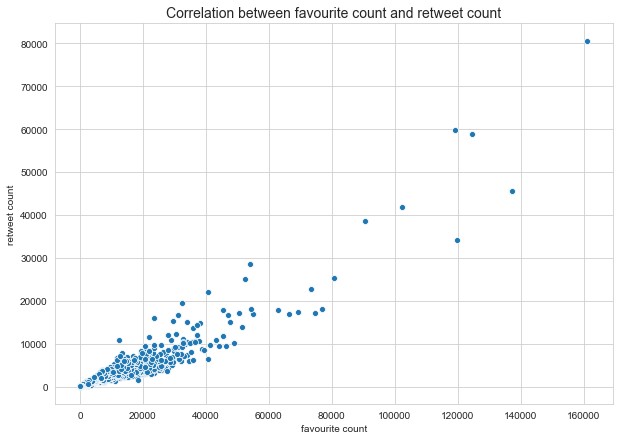

In [664]:
sns.set_style('whitegrid');

f, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x='favorite_count', y='retweet_count', data=dogrates_df, ax=ax);
ax.set_title('Correlation between favourite count and retweet count', fontsize=14);
ax.set(xlabel='favourite count', ylabel='retweet count');

### Insight
There is a strong corelation between the more favourited tweets and the more retweeted ones

### Question 4
Is there a correlation between high rated dogs and its favourite / retweet counts?

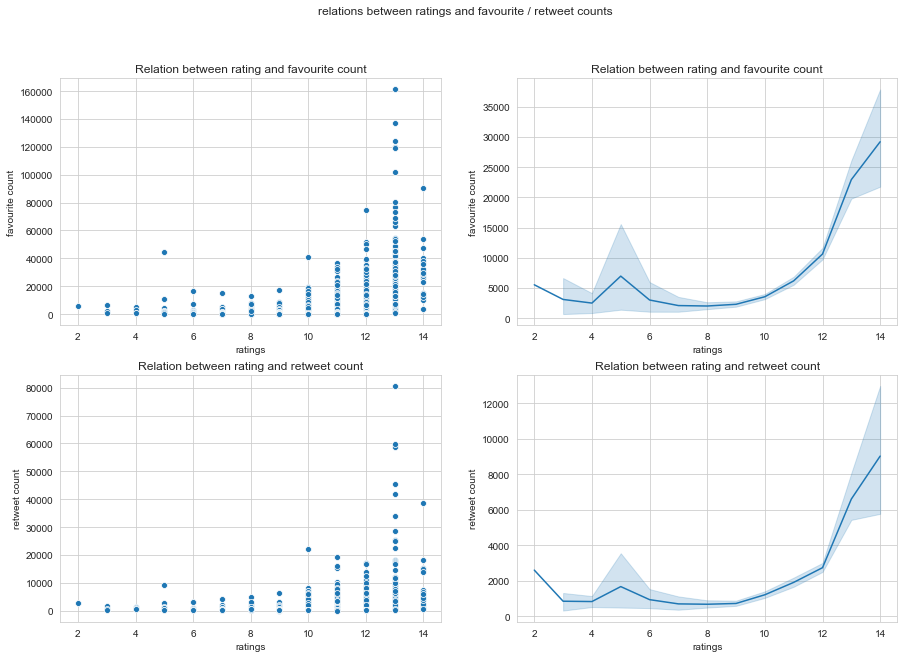

In [657]:
f, ax = plt.subplots(2, 2, figsize=(15,10))
f.suptitle('relations between ratings and favourite / retweet counts')

sns.scatterplot(data=dogrates_df, x='rating_numerator', y='favorite_count', ax=ax[0][0]);
ax[0][0].set_title('Relation between rating and favourite count');
ax[0][0].set(xlabel='ratings', ylabel='favourite count');

sns.lineplot(data=dogrates_df, x='rating_numerator', y='favorite_count', ax=ax[0][1]);
ax[0][1].set_title('Relation between rating and favourite count');
ax[0][1].set(xlabel='ratings', ylabel='favourite count');

sns.scatterplot(data=dogrates_df, x='rating_numerator', y='retweet_count', ax=ax[1][0]);
ax[1][0].set_title('Relation between rating and retweet count');
ax[1][0].set(xlabel='ratings', ylabel='retweet count');

sns.lineplot(data=dogrates_df, x='rating_numerator', y='retweet_count', ax=ax[1][1]);
ax[1][1].set_title('Relation between rating and retweet count');
ax[1][1].set(xlabel='ratings', ylabel='retweet count');

### Insight
There are a few spikes where low ratings have got a high number of favourites or retweets. However in general (and over the rating of 10), the number of retweets and favourites are higher for the higher rated pooches.

### Question 5
Which are the max retweeted and max favourited dog breeds (top 3) and what are their ratings?

In [594]:
# Let's use a sum of the retweet and favourite count
dogrates_df.loc[:,'social_count'] = dogrates_df['favorite_count'] + dogrates_df['retweet_count']
dogrates_df.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed,favorite_count,retweet_count,social_count
413,783391753726550016,2016-10-04 19:42:03+00:00,iPhone,Meet Godi. He's an avid beachgoer and part tim...,https://twitter.com/dog_rates/status/783391753...,13,10,Godi,None,None,None,None,Norwegian Elkhound,17670,5796,23466
1218,672995267319328768,2015-12-05 04:25:50+00:00,iPhone,This is Pumpkin. He can look in two different ...,https://twitter.com/dog_rates/status/672995267...,8,10,Pumpkin,None,None,None,None,French Bulldog,949,292,1241
7,890240255349198849,2017-07-26 15:59:51+00:00,iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,Pembroke,30767,6953,37720
1433,666407126856765440,2015-11-17 00:06:54+00:00,iPhone,This is a southern Vesuvius bumblegruff. Can d...,https://twitter.com/dog_rates/status/666407126...,7,10,a,None,None,None,None,Black-And-Tan Coonhound,103,36,139
128,854365224396361728,2017-04-18 16:05:17+00:00,iPhone,This is Einstein. He's having a really good da...,https://twitter.com/dog_rates/status/854365224...,13,10,Einstein,None,None,None,None,Pembroke,18916,4689,23605


In [595]:
col_mask = ['tweet_id', 'dog_breed', 'rating_numerator', 'social_count']
dogrates_df.sort_values(by='social_count', ascending=False).head(10)[col_mask]

,tweet_id,dog_breed,rating_numerator,social_count
607,744234799360020481,Labrador Retriever,13,241786
319,807106840509214720,Chihuahua,13,183279
243,822872901745569793,Lakeland Terrier,13,182853
632,739238157791694849,Eskimo Dog,13,178830
94,866450705531457537,French Bulldog,13,153835
51,879415818425184262,English Springer,13,144114
263,819004803107983360,Standard Poodle,14,129269
81,870374049280663552,Golden Retriever,13,105896
106,862096992088072192,Chow,13,95926
56,877736472329191424,Chesapeake Bay Retriever,13,94831


In [596]:
dogrates_df.query('rating_numerator == 14').sort_values(by='social_count', ascending=False).head(10)[col_mask]

,tweet_id,dog_breed,rating_numerator,social_count
263,819004803107983360,Standard Poodle,14,129269
235,825535076884762624,Rottweiler,14,72271
44,881536004380872706,Samoyed,14,62750
288,813812741911748608,French Bulldog,14,52870
623,740373189193256964,Golden Retriever,14,49474
55,878057613040115712,French Bulldog,14,47064
247,822462944365645825,Pomeranian,14,44669
129,854120357044912130,Black-And-Tan Coonhound,14,39543
7,890240255349198849,Pembroke,14,37720
201,831911600680497154,Bloodhound,14,35351


In [639]:
dogrates_grouped = dogrates_df.groupby('dog_breed').agg({'rating_numerator': ['mean'], 'social_count': ['sum']})
dogrates_grouped.columns = dogrates_grouped.columns.get_level_values(0)

In [642]:
dogrates_grouped.sort_values(by=['rating_numerator', 'social_count'], ascending=False).head(10)

,rating_numerator,social_count
dog_breed,,
Saluki,12.500000,109950
Briard,12.333333,34873
Tibetan Mastiff,12.250000,60803
Border Terrier,12.142857,111250
Silky Terrier,12.000000,8590
Standard Schnauzer,12.000000,2730
Eskimo Dog,11.777778,341418
Irish Setter,11.750000,52015
Gordon Setter,11.750000,29673


In [641]:
dogrates_grouped.sort_values(by=['social_count', 'rating_numerator'], ascending=False).head(10)

,rating_numerator,social_count
dog_breed,,
Golden Retriever,11.580882,2076503
Labrador Retriever,11.086957,1337546
Pembroke,11.443182,1212659
Chihuahua,10.692308,867123
Samoyed,11.743590,653693
French Bulldog,11.240000,560507
Chow,11.609756,499044
Pug,10.240741,390250
Cocker Spaniel,11.296296,388128


### Insight
The highest shared (favorites + retweets) dogs are mostly rated 13 with just one 14 rated dog in the top 10.

### Question 6
What is the spread of ratings? What are the most common ratings?

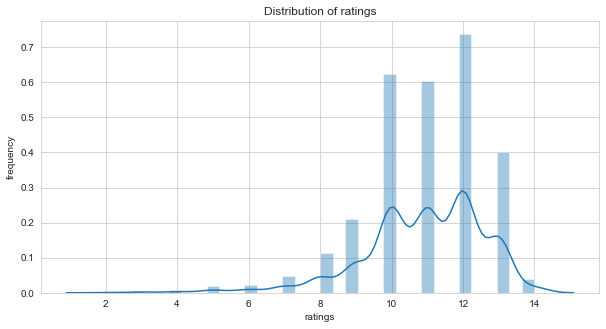

In [668]:
f, ax = plt.subplots(figsize=(10,5))
sns.distplot(dogrates_df['rating_numerator'], ax=ax);
ax.set_title('Distribution of ratings');
ax.set(xlabel='ratings', ylabel='frequency');

### Insights
The most common ratings are between 10 and 12. Rating of 13 and 14 are less common, with 14 being the least common. That shows that ratings of 14 have to be 'earned' by the doggos